In [39]:
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.transform import Rotation
import torch
import torch.nn as nn
import torch.nn.functional as F

import sys
sys.path.append("/home/shihab/repo/src")
from analysis_utils import convert_to_tensors, shuffle_and_split, prepare_vectors
from utils import save_parameters_to_csv

torch.manual_seed(42)
np.random.seed(41)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

## Two body: Using New non-buggy data

Along with comparsion with RPY

Comment (4/26):
+ We ignored a term so far: $V_{t} = f1(Xt, Xs).Fs + f2(Xt, Xs).Ft$

Comments (03/18):

+ The weird wave-y error plot for NN: converting ReLU's to Tanh got rid of those.
+ Turns out we can remove the Tanh activation on the very last layer
+ Looks like somewhere around 5-6 dist RPY overtakes us. Tried a little bit learning for larger distance- doesn't make much difference *for sphere*.

In [2]:
df = pd.read_csv(f"../data/sphere_2body_28k.csv").drop(columns=['Unnamed: 0'])
df.shape, df.columns

((28000, 23),
 Index(['center_x', 'center_y', 'center_z', 'dist', 'min_dist', 'force_x',
        'force_y', 'force_z', 'torque_x', 'torque_y', 'torque_z', 'vel_x',
        'vel_y', 'vel_z', 'angvel_x', 'angvel_y', 'angvel_z', 'quat_6d_1',
        'quat_6d_2', 'quat_6d_3', 'quat_6d_4', 'quat_6d_5', 'quat_6d_6'],
       dtype='object'))

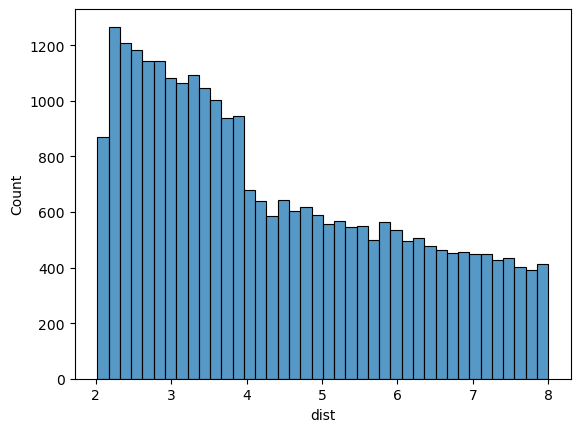

In [3]:
sns.histplot(df["dist"], bins=40);

In [4]:
df = df.rename(columns={'dist': 'r'})
#median_r = df['r'].median()
median_r = (df['r'].max()+df['r'].min())/2
print(median_r)
tmp = df['r'] - median_r #dont scale r, since we divide by it later

df['r2'] = tmp**2
df['r4'] = tmp**4

cols = df.columns.tolist()
i = cols.index('r')
new_cols = (
    cols[:i+1]
  + ['r2','r4']
  + [c for c in cols[i+1:] if c not in ('r2','r4')]
)
df = df[new_cols]

5.010055361296345


In [5]:
def prepare_vectors(df):
    force_cols = [
        'force_x', 'force_y', 'force_z',
        'torque_x', 'torque_y', 'torque_z',
    ]
    output_cols = [
        'vel_x', 'vel_y', 'vel_z',
        'angvel_x', 'angvel_y', 'angvel_z'
    ]
    #feature_cols = [col for col in df.columns if col not in (force_cols + output_cols)]
    feature_cols = ['center_x', 'center_y', 'center_z', 'r', 'r2', 'r4', 'min_dist']
    print("Using features:", feature_cols)
    
    dist_vec   = df[feature_cols].values
    force_vec  = df[force_cols].values
    output_vec = df[output_cols].values
    return dist_vec, force_vec, output_vec

In [6]:
feat, force, vel = prepare_vectors(df)
feat, force, vel = convert_to_tensors(feat, force, vel)

#vel *= 5

tmp = list(shuffle_and_split(df, feat, force, vel, split_frac=.8))

for i in range(len(tmp)):
    tmp[i] = tmp[i].to(device)

(train_dist_tensor, val_dist_tensor, 
    train_force_tensor, val_force_tensor, 
    train_velocity_tensor, val_velocity_tensor) = tmp

train_dist_tensor.shape, train_force_tensor.shape, val_dist_tensor.shape

Using features: ['center_x', 'center_y', 'center_z', 'r', 'r2', 'r4', 'min_dist']


(torch.Size([22400, 7]), torch.Size([22400, 6]), torch.Size([5600, 7]))

In [7]:
df['r']

0        4.345388
1        5.168057
2        4.096688
3        2.386303
4        3.626723
           ...   
27995    4.492878
27996    3.084181
27997    4.091191
27998    3.193333
27999    3.845449
Name: r, Length: 28000, dtype: float64

In [8]:
def L1(d):
    """ Computes the outer product of each 3D vector in the batch with itself. """
    # d: [batch_size, 3]
    return torch.einsum('bi,bj->bij', d, d)  # [batch_size, 3, 3]

def L2(d):
    """ Returns the matrix (I - outer(d, d)) for each vector in the batch. """
    # Identity tensor expanded to batch size
    batch_size = d.shape[0]
    I = torch.eye(3).unsqueeze(0).repeat(batch_size, 1, 1).to(device)  # [batch_size, 3, 3]
    ddT = torch.einsum('bi,bj->bij', d, d)  # [batch_size, 3, 3]
    return I - ddT

# Predefine the Levi-Civita tensor
levi_civita = torch.zeros(3, 3, 3, dtype=torch.float)
levi_civita[0, 1, 2] = 1
levi_civita[1, 2, 0] = 1
levi_civita[2, 0, 1] = 1
levi_civita[0, 2, 1] = -1
levi_civita[2, 1, 0] = -1
levi_civita[1, 0, 2] = -1

levi_civita = levi_civita.to(device)

def L3(d):
    """ Computes the cross product matrix for each 3D vector in the batch. """
    # Using einsum for batched matrix-vector multiplication:
    return torch.einsum('ijk,bk->bij', levi_civita, d)  # [batch_size, 3, 3]

def spsd_loss_func(sym_matrix, epsilon=1e-6):
    """SPSD loss representing SPSD violation
    """
    eigenvalues = torch.linalg.eigvalsh(sym_matrix)  # (batch_size, 6)
    negative_violations = torch.relu(-eigenvalues + epsilon)  # (batch_size, 6)
    loss = torch.mean(negative_violations)
    
    return loss

In [9]:
viscosity = 1.0
eigens = []

class ScNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ScNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 5),
            #nn.Tanh()
        )
        
    def forward(self, r, print_scalars=False):
        x = self.layers(r)
        return x

    def predict_mobility(self, X, print_scalars=False):
        d_vec, r = X[:,:3], X[:,3]
        sc = self.forward(X[:, 3:], print_scalars) #exclude d_vec

        d_vec = -d_vec/ r.unsqueeze(-1) # negative,cz dvec=target-src
        TT = sc[:, 0].unsqueeze(1).unsqueeze(2) * L1(d_vec) + \
                sc[:, 1].unsqueeze(1).unsqueeze(2) * L2(d_vec) # TODO: d_vec or r?
        RT = sc[:, 2].unsqueeze(1).unsqueeze(2) * L3(d_vec)
        RR = sc[:, 3].unsqueeze(1).unsqueeze(2) * L1(d_vec) + \
                sc[:, 4].unsqueeze(1).unsqueeze(2) * L2(d_vec)
    
        K = torch.zeros((len(X), 6, 6), dtype=torch.float32, device=X.device)

        # After experiments, the kernel is NOT symmetric. 
        # Top-right and bottem left should NOT be transpose of each other
        K[:, :3, :3] = TT  # Top-left block
        K[:, 3:, :3] = RT  # Bottom-left block
        K[:, :3, 3:] = RT  # Top-right block (transpose of B)
        K[:, 3:, 3:] = RR  # Bottom-right block

        nonSPD = 0
        nonSym = 0
        global eigens
        if not self.training:
            print("Activating SPSD check..")
            for i in range(len(K)):
                k66 = K[i].detach().cpu()
                eigs = np.linalg.eigvals(k66)
                if not np.all(eigs>=- 1e-8):
                    eigens.append((eigs.min(), eigs.max()))
                    nonSPD += 1
                if not np.allclose(k66, k66.T, atol=1e-4):
                    nonSym += 1
                    
            print(f"{nonSPD=}, {nonSym=}, {len(K)}")
        return K

    def predict_velocity(self, X, force, return_M=False):
        M = self.predict_mobility(X)/viscosity
        velocity = torch.bmm(M, force.unsqueeze(-1)).squeeze(-1)
        if return_M:
            return velocity, M
        return velocity


## Modelling

In [10]:
input_dim = train_dist_tensor.shape[1] - 3
print(input_dim)
batch_size = 256
epochs = 400
model = ScNetwork(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.50)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)


criterion = nn.L1Loss()
#criterion = nn.MSELoss()
n_iter = train_velocity_tensor.shape[0]//batch_size
n_iter, n_iter*batch_size, len(train_dist_tensor)

4


(87, 22272, 22400)

In [11]:
def shuffle_tensors(*tensors):
    """ Shuffles multiple tensors in the same order """
    indices = torch.randperm(tensors[0].size(0),device=device)  # Generate random indices
    return tuple(tensor[indices] for tensor in tensors)
    
losses = []
data_losses, spsd_losses = [], []
for epoch in range(epochs):
    model.train()
    avg = 0
    avg_data, avg_spsd = 0, 0
    
    train_dist_tensor, train_force_tensor, train_velocity_tensor = shuffle_tensors(
        train_dist_tensor, train_force_tensor, train_velocity_tensor
    )
    for it in range(n_iter):
        optimizer.zero_grad()
        
        indices = torch.arange(it*batch_size, (it+1)*batch_size, dtype=torch.int).cuda()
        
        X = train_dist_tensor[indices]  
        force = train_force_tensor[indices] 
        Y = train_velocity_tensor[indices]  
    
        batch_output, M = model.predict_velocity(X, force, return_M=True)

        # Compute loss
        data_loss = criterion(batch_output, Y)
        spsd_loss = 0.0 * spsd_loss_func(M)
        loss = data_loss + spsd_loss
        
        loss.backward()
        avg += loss.item()
        avg_data += data_loss.item()
        avg_spsd += spsd_loss.item()
        optimizer.step()
        

    scheduler.step()
    if epoch%5==0:
        print(f'Epoch {epoch}, Loss: {avg/n_iter}')
        losses.append(avg/n_iter)
        data_losses.append(avg_data/n_iter)
        spsd_losses.append(avg_spsd/n_iter)

torch.save(model.state_dict(), "sphere_2body.wt")

Epoch 0, Loss: 0.18127789900734506
Epoch 5, Loss: 0.021203602450075507
Epoch 10, Loss: 0.018034886718652714
Epoch 15, Loss: 0.018347176819525916
Epoch 20, Loss: 0.014225146219391248
Epoch 25, Loss: 0.016676820407824956
Epoch 30, Loss: 0.012681054229708924
Epoch 35, Loss: 0.012689757257186133
Epoch 40, Loss: 0.009114465753858289
Epoch 45, Loss: 0.011908838910789326
Epoch 50, Loss: 0.007970420298455605
Epoch 55, Loss: 0.008416804800816309
Epoch 60, Loss: 0.007201973244483615
Epoch 65, Loss: 0.007138529867362017
Epoch 70, Loss: 0.006106371126919128
Epoch 75, Loss: 0.005986776395604528
Epoch 80, Loss: 0.005391463203805274
Epoch 85, Loss: 0.006363751125875218
Epoch 90, Loss: 0.006132946729702854
Epoch 95, Loss: 0.004711242812824832
Epoch 100, Loss: 0.004274259488654976
Epoch 105, Loss: 0.004795342713230471
Epoch 110, Loss: 0.0036709161124716715
Epoch 115, Loss: 0.0037544925252896272
Epoch 120, Loss: 0.0031879098066289364
Epoch 125, Loss: 0.003029670701469241
Epoch 130, Loss: 0.0027569731196

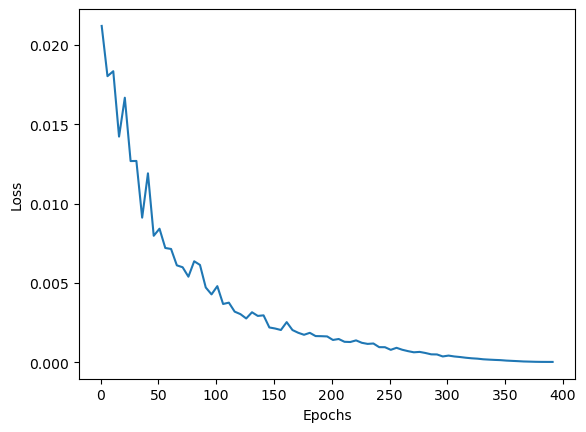

In [12]:
import matplotlib.pyplot as plt
los = losses[1:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los);
plt.ylabel("Loss")
plt.xlabel("Epochs");
#plt.savefig("loss.png");

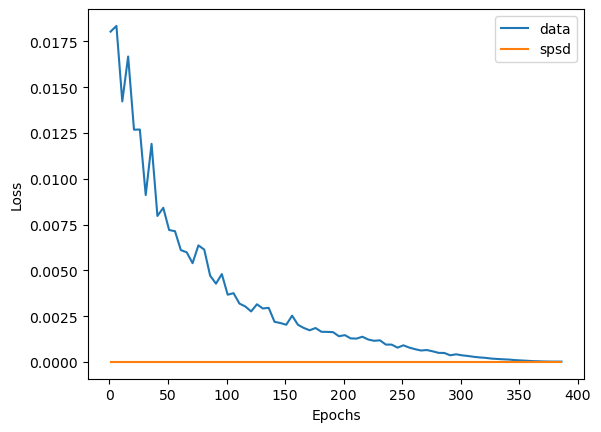

In [13]:
SKIP = 2
los = data_losses[SKIP:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los, label='data');

los = spsd_losses[SKIP:] # first one is usually too big, messes up the plot
plt.plot(np.arange(len(los))*5+1, los, label='spsd');

plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epochs");

In [14]:
data_losses[:5], data_losses[-5:], spsd_losses[:5], spsd_losses[-5:]

([0.18127789900734506,
  0.021203602450075507,
  0.018034886718652714,
  0.018347176819525916,
  0.014225146219391248],
 [3.566383948682101e-05,
  2.4918835956721042e-05,
  1.9371654161659535e-05,
  1.759968124353126e-05,
  1.6891484836838342e-05],
 [0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0])

## Evaluation

In [15]:
model = ScNetwork(input_dim).to(device)
model.load_state_dict(torch.load("sphere_2body.wt", weights_only=True))
model.eval()

eigens = []
with torch.no_grad():
    val_output, M = model.predict_velocity(val_dist_tensor, val_force_tensor, return_M=True)

Activating SPSD check..
nonSPD=0, nonSym=5600, 5600


In [40]:
directory = "/home/shihab/programs/QPGD/data/sphere"
save_parameters_to_csv(model, directory)

Parameters saved to /home/shihab/programs/QPGD/data/sphere directory.


In [17]:
print(len(eigens))
if eigens:
    eigens = np.array(eigens)
    plt.hist(eigens[:,0], bins=40);

0


In [18]:
torch.set_printoptions(sci_mode=False, precision=6)
jj = 199
val_output[jj], val_velocity_tensor[jj]

(tensor([ 0.084797, -0.053552, -0.046315,  0.009330,  0.005655,  0.008121],
        device='cuda:0'),
 tensor([ 0.084816, -0.053564, -0.046321,  0.009336,  0.005663,  0.008124],
        device='cuda:0'))

In [19]:
criterion = nn.L1Loss(reduction='none') 
err = criterion(val_output, val_velocity_tensor)

rmse = err.mean(axis=0)

print("Root Mean Squared error for each of 6 output variables:\n", rmse)
print("Actual Magnitude:\n ", torch.abs(val_velocity_tensor).mean(axis=0))
print("RMSE:", err.mean())

Root Mean Squared error for each of 6 output variables:
 tensor([    0.000020,     0.000020,     0.000022,     0.000013,     0.000013,
            0.000013], device='cuda:0')
Actual Magnitude:
  tensor([0.137929, 0.138942, 0.139380, 0.024973, 0.025055, 0.024663],
       device='cuda:0')
RMSE: tensor(    0.000017, device='cuda:0')


In [20]:
#### Median Relative Absolute Error
def mean_abs_err(val_output, val_velocity_tensor, npp=False):
    # 6D vector: median % error for each vel component
    valid_mask = torch.abs(val_velocity_tensor) > 1e-6
    
    filtered_y_tensor = torch.where(valid_mask, val_velocity_tensor, torch.tensor(float('nan')))
    relative_error = torch.abs((val_output - filtered_y_tensor) / filtered_y_tensor)
    
    a = torch.nanmean(relative_error, dim=0)
    return a*100

mean_abs_err(val_output, val_velocity_tensor)

tensor([0.031098, 0.058479, 0.023238, 0.216619, 0.198868, 0.151540],
       device='cuda:0')

In [21]:
100*rmse/torch.abs(val_velocity_tensor).mean(axis=0)

tensor([0.014436, 0.014720, 0.015474, 0.050240, 0.051089, 0.050997],
       device='cuda:0')

In [22]:
idx = val_dist_tensor[:,3]<4.0
mean_abs_err(val_output[idx], val_velocity_tensor[idx])

tensor([0.039339, 0.071380, 0.023552, 0.149141, 0.150038, 0.068575],
       device='cuda:0')

In [23]:
idx = val_dist_tensor[:,3]<2.5
mean_abs_err(val_output[idx], val_velocity_tensor[idx])

tensor([0.120618, 0.234570, 0.066222, 0.406001, 0.267442, 0.162145],
       device='cuda:0')

## Nearfield

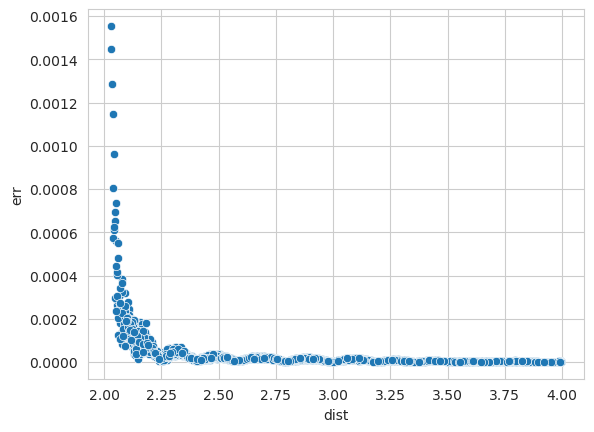

In [24]:
err = torch.abs(val_output-val_velocity_tensor).mean(axis=1)

tdf = pd.DataFrame({
    'dist': val_dist_tensor[:,3].cpu().numpy(),
    'err': err.detach().cpu().numpy()
})
xdf = tdf[tdf['dist']<4.0]
xdf = xdf[xdf['err']<.002]

sns.set_style("whitegrid")
# ax = sns.regplot(x='dist', y='err', data=tdf, scatter_kws={'color':'blue', 'alpha':0.15}, 
#              line_kws={'color':'red'}, order=2);
ax = sns.scatterplot(x='dist', y='err', data=xdf)
plt.savefig("figs/dist_acc.eps");

In [25]:
len(tdf)

5600

## RPY

In [26]:
viscosity = 1.0


import sys
sys.path.insert(0, '/home/shihab/hignn')
from grpy_tensors import mu  #using non-torch original version

def compute_rpy_mobility(c2, return_k=False):
    global viscosity
    c = np.array([[0.0, 0.0, 0.0], list(c2)])
    radii = np.array([1.0, 1.0])  # Example radii of the particles
    
    M = mu(c, radii,blockmatrix=True)/viscosity
    res = M[:,:,0,1,:,:] #M_ji, not M_ij. (RT,TR components vary)
    K = np.zeros((6,6))
    K[:3,:3] = res[0,0]
    K[:3,3:] = res[0,1]
    K[3:,:3] = res[1,0]
    K[3:,3:] = res[1,1]

    #K = M
    return K

len_val = len(val_dist_tensor)
val_dist_arr = val_dist_tensor.cpu().numpy()
val_force_arr = val_force_tensor.cpu().numpy()
val_velocity_arr = val_velocity_tensor.cpu().numpy()
rpy_vels = np.zeros((len_val,6))
for i in range(len_val):
    x,f = val_dist_arr[i], val_force_arr[i]
    #f = np.concatenate((np.zeros_like(f), f))
    yp = compute_rpy_mobility(x[:3]) @ f
    rpy_vels[i] = yp[:6]

rpy_vels_tensor = torch.Tensor(rpy_vels).cuda()
mean_abs_err(rpy_vels_tensor, val_velocity_tensor)

tensor([3.492450, 5.691768, 2.517040, 5.969756, 7.976567, 3.507649],
       device='cuda:0')

In [27]:
mean_abs_err(val_output, val_velocity_tensor)

tensor([0.031098, 0.058479, 0.023238, 0.216619, 0.198868, 0.151540],
       device='cuda:0')

In [28]:
ii = 16
rpy_vels_tensor[ii], val_velocity_tensor[ii], val_output[ii], val_dist_arr[ii, 3]

(tensor([-0.326567,  0.248947,  0.090172, -0.019030, -0.042033, -0.066604],
        device='cuda:0'),
 tensor([-0.330721,  0.258887,  0.090409, -0.019487, -0.042268, -0.066256],
        device='cuda:0'),
 tensor([-0.330771,  0.258933,  0.090419, -0.019489, -0.042282, -0.066266],
        device='cuda:0'),
 2.7156386)

In [29]:
len(val_output)

5600

In [30]:
rpy_err = torch.abs(rpy_vels_tensor-val_velocity_tensor).mean(axis=1)

tdf['rpy_err'] = rpy_err.detach().cpu().numpy()

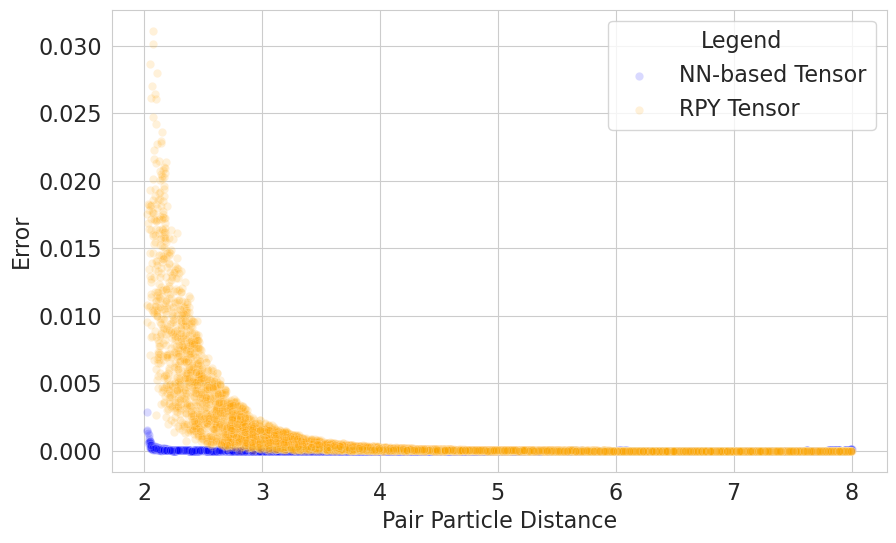

In [31]:
def show_err_plot(tdf, rpy_plot=True, file=None):
    sns.set_style("whitegrid")
    plt.rcParams.update({'font.size': 16})  # Adjust the font size as needed

    # Create a figure and a single axes object
    fig, ax = plt.subplots(figsize=(10, 6))

    # Scatter plot for NN-based tensor error
    sns.scatterplot(x='dist', y='err', data=tdf, ax=ax,
                    color='blue', alpha=0.15, label='NN-based Tensor')

    # Scatter plot for RPY tensor error
    if rpy_plot:
        sns.scatterplot(x='dist', y='rpy_err', data=tdf, ax=ax,
                        color='orange', alpha=0.15, label='RPY Tensor')

    # Set axis labels
    ax.set_xlabel("Pair Particle Distance")
    ax.set_ylabel("Error")

    # Create legend
    ax.legend(title='Legend')

    # Save and show the plot
    if file is not None:
        plt.savefig(file)
    plt.show()

show_err_plot(tdf, True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


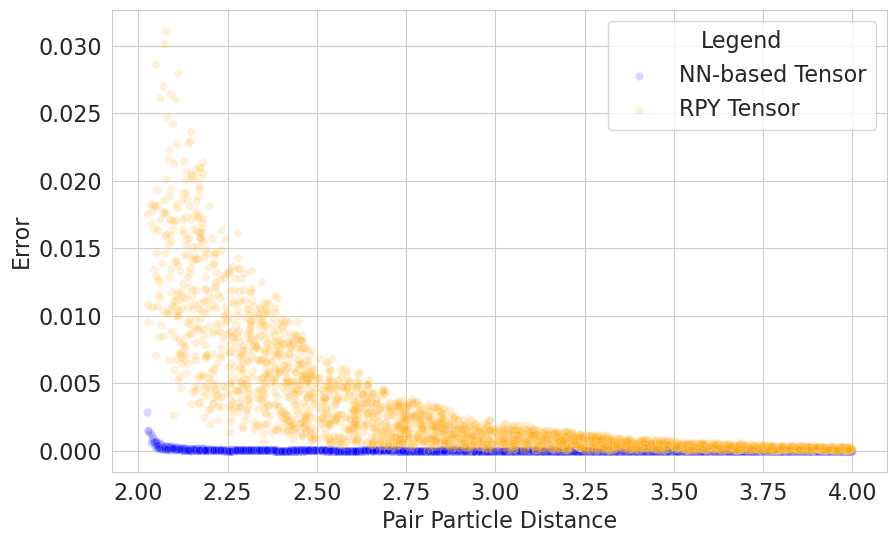

In [32]:
Lim = 4.0
show_err_plot(tdf[tdf['dist']<Lim], file="figs/rpy_4.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


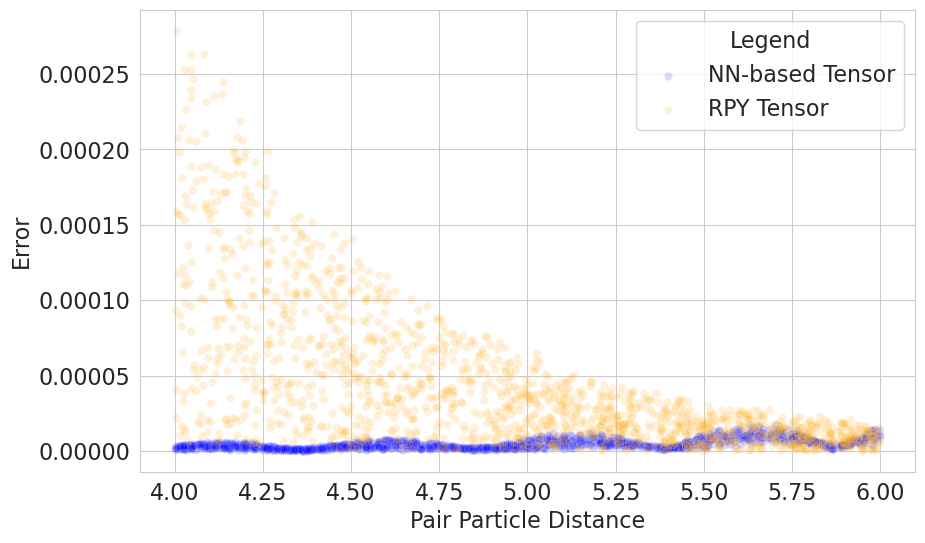

In [33]:
idx = (tdf['dist']>=4.0) & (tdf['dist']<6.0)
show_err_plot(tdf[idx], file="figs/rpy_6.eps")

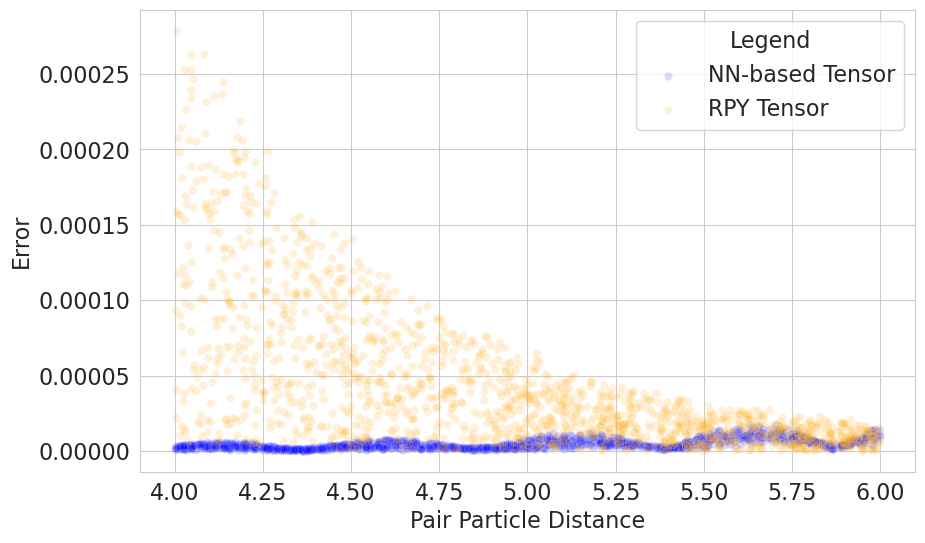

In [34]:
idx = (tdf['dist']>=4.0) & (tdf['dist']<6.0)
show_err_plot(tdf[idx])

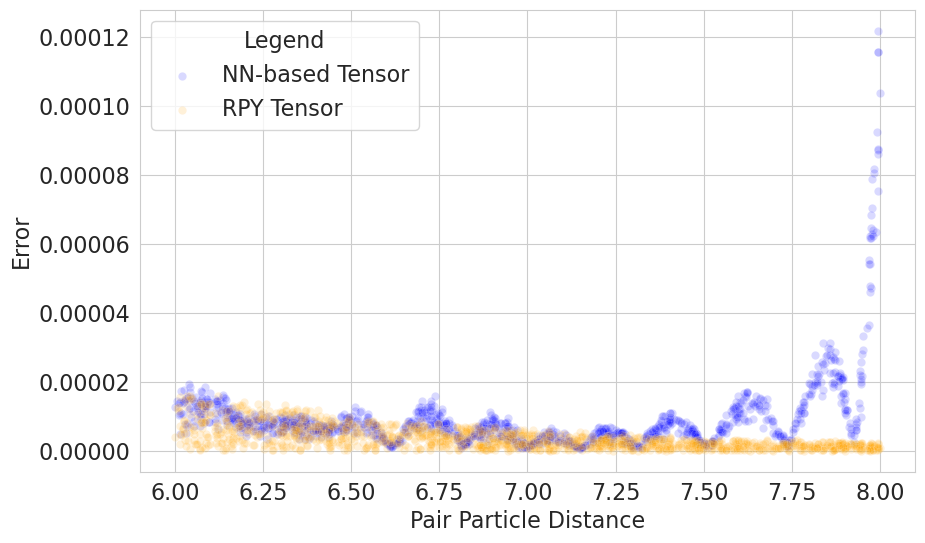

In [35]:
idx = (tdf['dist']>=6.0) & (tdf['dist']<8.0)
show_err_plot(tdf[idx])

In [36]:
cols = ["vel_x", "vel_y", "vel_z",
    "angvel_x", "angvel_y", "angvel_z"]
xdf = df[df['r']>6.0]
np.abs(xdf[cols]).mean()

vel_x       0.075143
vel_y       0.075651
vel_z       0.074773
angvel_x    0.006274
angvel_y    0.006240
angvel_z    0.006282
dtype: float64

In [37]:
xdf = df[df['dist']<8.0]
np.abs(xdf[cols]).mean()

KeyError: 'dist'

In [ ]:
t = .416
p = .432

abs(t-p)/t*100

In [ ]:
t = .07824
p = .0897

abs(t-p)/t*100

In [ ]:
t = 0.31859
p = 0.330

abs(t-p)/t*100

In [ ]:
t = 0.06925
p = 0.07312

abs(t-p)/t*100